In [9]:
import sys
sys.path.append('..')
from tsai.utils import *
from tsai.basics import *
from matplotlib import dates as mdates
import sklearn
my_setup(sklearn)
from swdf.utils import generate_preprocessed_data


os              : Linux-6.8.0-39-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


# DST and AP Geomagnetic Indices Data Preprocessing

In [10]:
config_geo = yaml2dict('./config/geodstap.yaml', attrdict=True)
config_geo = config_geo.data
config = AttrDict(config_geo)
config

```json
{ 'ap_config': './config/geoap.yaml',
  'data_nb': './geodstap_data.ipynb',
  'df_save_path': './preprocessed_data/dataframes/geodstap.pkl',
  'dst_config': './config/geodst.yaml',
  'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_geodstap.pkl'}
```

In [18]:
ap_config = yaml2dict(config.ap_config, attrdict=True).data
df_ap, _ = generate_preprocessed_data(ap_config, generate_preproc_pipe=False)

df_ap.head()

,hh._m,days,AP,Datetime
0,1.5,0.000,18,1932-01-01 00:00:00
1,4.5,0.125,12,1932-01-01 03:00:00
2,7.5,0.250,9,1932-01-01 06:00:00
3,10.5,0.375,12,1932-01-01 09:00:00
4,13.5,0.500,18,1932-01-01 12:00:00


In [12]:
dst_config = yaml2dict(config.dst_config, attrdict=True).data
df_dst, _ = generate_preprocessed_data(dst_config, generate_preproc_pipe=False)

df_dst.set_index('Datetime', inplace=True)
df_dst = df_dst.resample('3H').mean().round(1)
df_dst = df_dst.reset_index()
df_dst

,Datetime,DST
0,1957-01-01 00:00:00,12.000000
1,1957-01-01 03:00:00,9.300000
2,1957-01-01 06:00:00,5.000000
3,1957-01-01 09:00:00,-5.000000
4,1957-01-01 12:00:00,0.000000
...,...,...
197518,2024-08-06 18:00:00,-14.300000
197519,2024-08-06 21:00:00,-18.700001
197520,2024-08-07 00:00:00,-17.299999
197521,2024-08-07 03:00:00,-16.000000


In [13]:
df_raw = df_ap.merge(df_dst, on='Datetime', how='right')
df_raw['DOY'] = df_raw['Datetime'].dt.dayofyear

columns = ['Datetime', 'DOY', 'DST', 'AP']
df_raw = df_raw[columns]

df_raw

,Datetime,DOY,DST,AP
0,1957-01-01 00:00:00,1,12.000000,2
1,1957-01-01 03:00:00,1,9.300000,3
2,1957-01-01 06:00:00,1,5.000000,3
3,1957-01-01 09:00:00,1,-5.000000,22
4,1957-01-01 12:00:00,1,0.000000,15
...,...,...,...,...
197518,2024-08-06 18:00:00,219,-14.300000,5
197519,2024-08-06 21:00:00,219,-18.700001,6
197520,2024-08-07 00:00:00,220,-17.299999,4
197521,2024-08-07 03:00:00,220,-16.000000,6


In [14]:
print(df_raw.isna().sum())

df_raw.dropna(inplace=True) # As are the values diverge between both indices

print(df_raw.isna().sum())

Datetime    0
DOY         0
DST         0
AP          0
dtype: int64
Datetime    0
DOY         0
DST         0
AP          0
dtype: int64


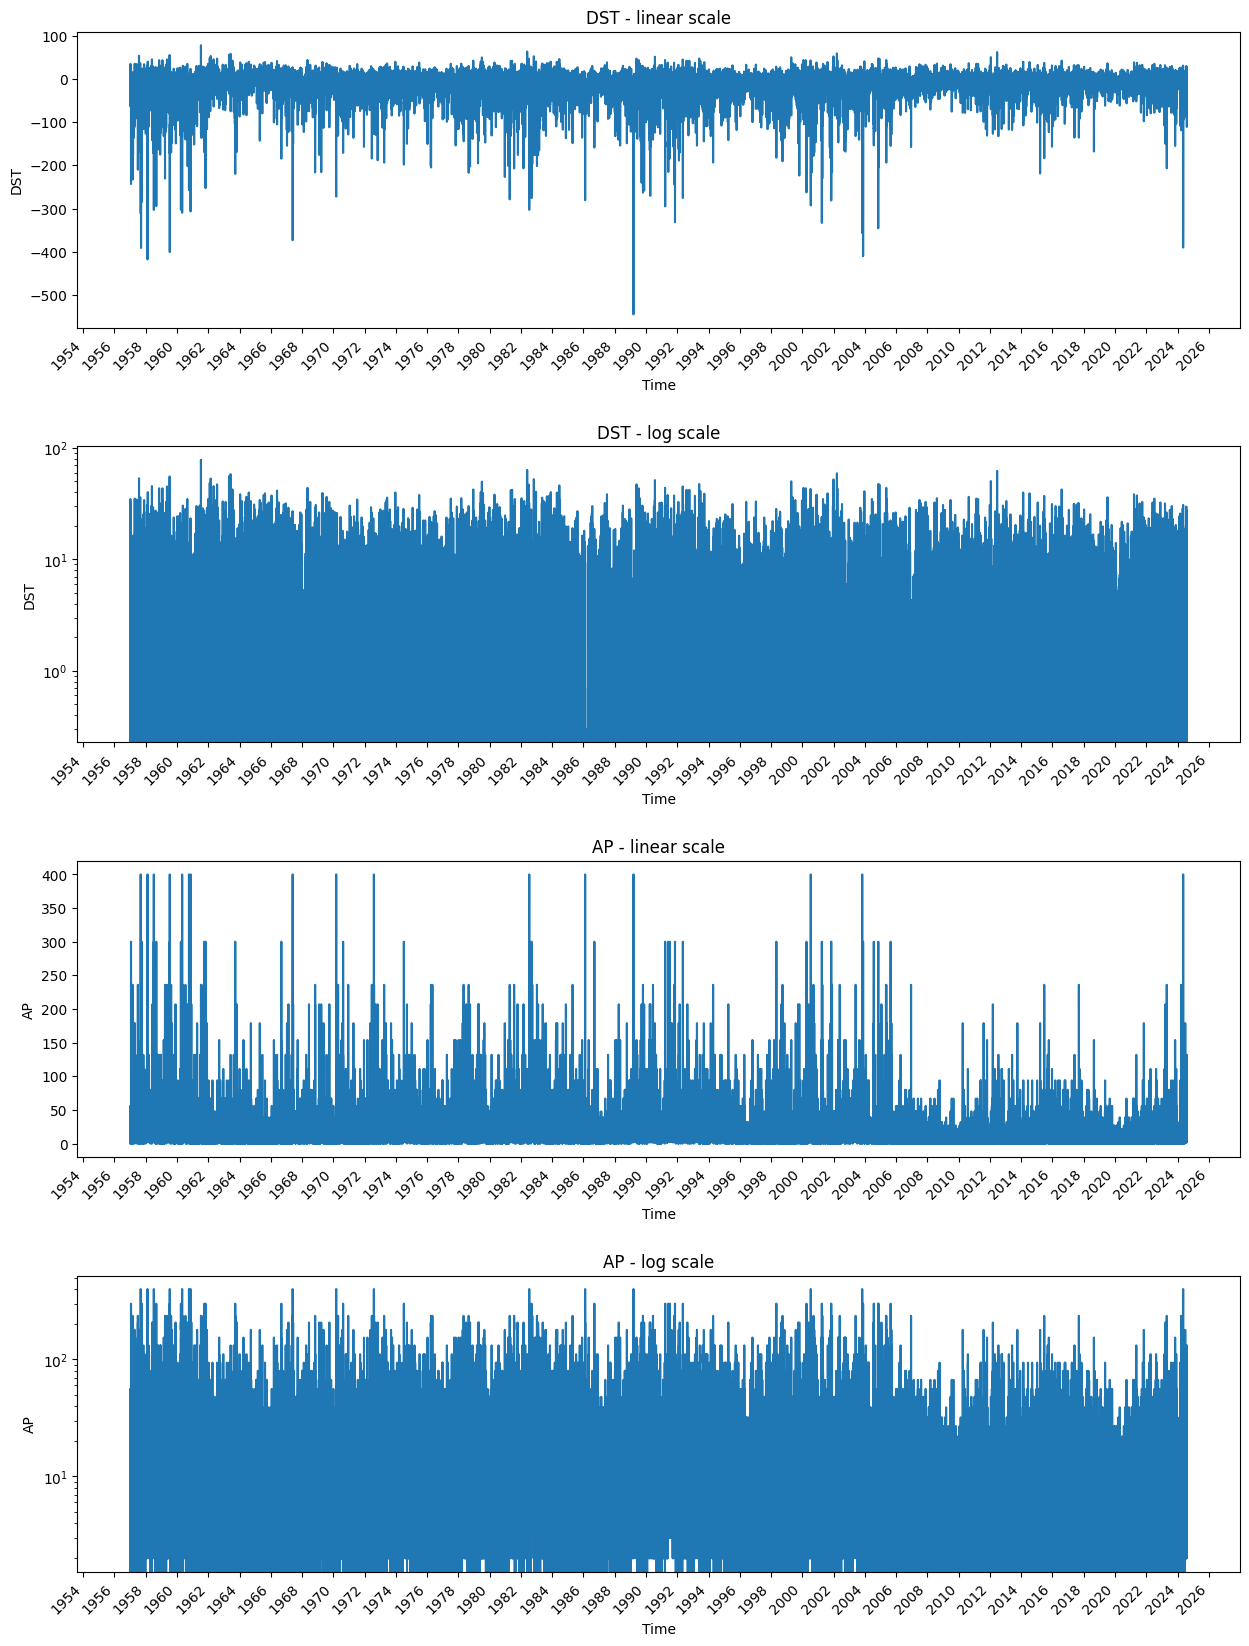

In [15]:
columns = ['DST', 'AP']
scales = ['linear', 'log']

fig, ax = plt.subplots(4, 1, figsize=(15, 20))
plt.subplots_adjust(hspace=0.4)

i = 0

for column in columns:
    for scale in scales:

        ax[i].set_yscale(scale)
        
        ax[i].plot(df_raw.Datetime, df_raw[column])
        
        ax[i].set_title(f'{column} - {scale} scale')
        ax[i].set_xlabel('Time')
        ax[i].set_ylabel(column)
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # format x-axis ticks
        
        ax[i].xaxis.set_major_locator(mdates.YearLocator(2))
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right")
        
        i += 1
      
plt.show()

In [16]:
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage and set the right dtypes
], verbose=True)

df = preproc_pipe.fit_transform(df_raw)
df

Initial memory usage: 3.39 MB   
Final memory usage  : 3.01 MB    (-11.1%)
[Pipeline] .......... (step 1 of 1) Processing shrinker, total=   0.0s


,Datetime,DOY,DST,AP
0,1957-01-01 00:00:00,1,12.000000,2
1,1957-01-01 03:00:00,1,9.300000,3
2,1957-01-01 06:00:00,1,5.000000,3
3,1957-01-01 09:00:00,1,-5.000000,22
4,1957-01-01 12:00:00,1,0.000000,15
...,...,...,...,...
197518,2024-08-06 18:00:00,219,-14.300000,5
197519,2024-08-06 21:00:00,219,-18.700001,6
197520,2024-08-07 00:00:00,220,-17.299999,4
197521,2024-08-07 03:00:00,220,-16.000000,6


In [17]:
save_object(df, config.df_save_path)
save_object(preproc_pipe, config.preproc_pipe_save_path)

preprocessed_data/dataframes directory already exists.
DataFrame saved as preprocessed_data/dataframes/geodstap.pkl
preprocessed_data/pipelines directory already exists.
Pipeline saved as preprocessed_data/pipelines/preproc_geodstap.pkl
